# Simulation_CLP_PID_FF

## import 

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import time
from datetime import datetime
import os
import math

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
import Package_LAB 
from Package_LAB import *
from importlib import reload
package_DBR= reload(package_DBR)
Package_LAB=reload(Package_LAB)
from Package_LAB import *

## variable immuable


In [97]:
TSim = 2700
Ts = 1
Nsim = int(TSim/Ts)

Tbroida = 162.91388213046346
theta_broida =38.4580785282409
Kp_broida = 0.33306127817093445


#Process parameters of MV (SOPTD)
Kp_MV = 0.3147256489891693
Tlag1 = 85.12053142218886
Tlag2 = 85.22644117696471
theta_MV = 4.428261249386976

#Process parameters of DV (SOPTD)
Kp_DV = 0.28042339631292282
Tlead1 = 82.57900936361463
Tlead2 = 55.24161229065938
theta_DV = 18.000012818797185

#parameters of the tclab :
MV0 = 50
PV0 = 59
DV0 = 50

#Parameters of the controller :
gamma = 0.7
Kc, Ti, Td = IMC_tuning(Kp_broida,Tbroida,0,theta_broida,gamma,'FOPDT-PID')
print(Kc, Ti, Td)
Ti = 150
alpha = 1
MVmin = 0
MVmax = 100


4.103550735253099 182.1429213945839 17.19900730795089


In [98]:
#Path :
MVManPath = {0:MV0, TSim:MV0}
SPPath = {0: PV0+5, 1200: PV0-5,TSim : PV0-5}
DVPath = {0:DV0, 2000:DV0+10, TSim:DV0+10}
ManPath = {0: True, 500: False, TSim : False}
ActivateFF = True
ManFF = False


In [99]:
t = []
MV = []
SP = []
PV = []
MVman = []
MVff = []
MVffDelay = []
MVffLL1 = []
Man= []
MVP = []
MVD = []
MVI = []
E = []
DV = []
PV1p = []
PV2p = []
PV1d = []
PV2d = []
MVDelayd = []
MVDelayp = []
for i in range(0, Nsim):
    t.append(i*Ts)
    
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath, t, DV)

    Delay_RT(DV-DV0*np.ones_like(DV), np.max([theta_DV-theta_MV, 0]), Ts, MVffDelay)
    Lead_lag_RT(MVffDelay,-Kp_DV/Kp_DV, Tlag1, Tlead1,Ts,MVffLL1)
    if ActivateFF:
        Lead_lag_RT(MVffLL1, 1, Tlag2, Tlead2, Ts, MVff)
    else :
        Lead_lag_RT(MVffLL1, 0, Tlag2, Tlead2, Ts, MVff)
    SelectPath_RT(MVManPath, t, MVman)
    SelectPath_RT(ManPath,t,Man)
    PID_RT(SP,PV,Man,MVman, MVff, Kc, Ti, Td,alpha, Ts,MVmin, MVmax, MV, MVP, MVI, MVD, E, ManFF, PV0)

    Delay_RT(MV, theta_MV, Ts, MVDelayp,MV0)
    FO_RT(MVDelayp, Kp_MV, Tlag1, Ts, PV1p,0)
    FO_RT(PV1p, 1, Tlag2, Ts, PV2p,0)

    Delay_RT(DV-DV0*np.ones_like(DV), theta_DV, Ts, MVDelayd,0)
    FO_RT(MVDelayd, Kp_DV, Tlead1, Ts, PV1d,0)
    FO_RT(PV1d, 1, Tlead2, Ts, PV2d,0)
    PV.append(PV2p[-1]+PV2d[-1]+PV0-Kp_MV*MV0)

 

## Plot Data

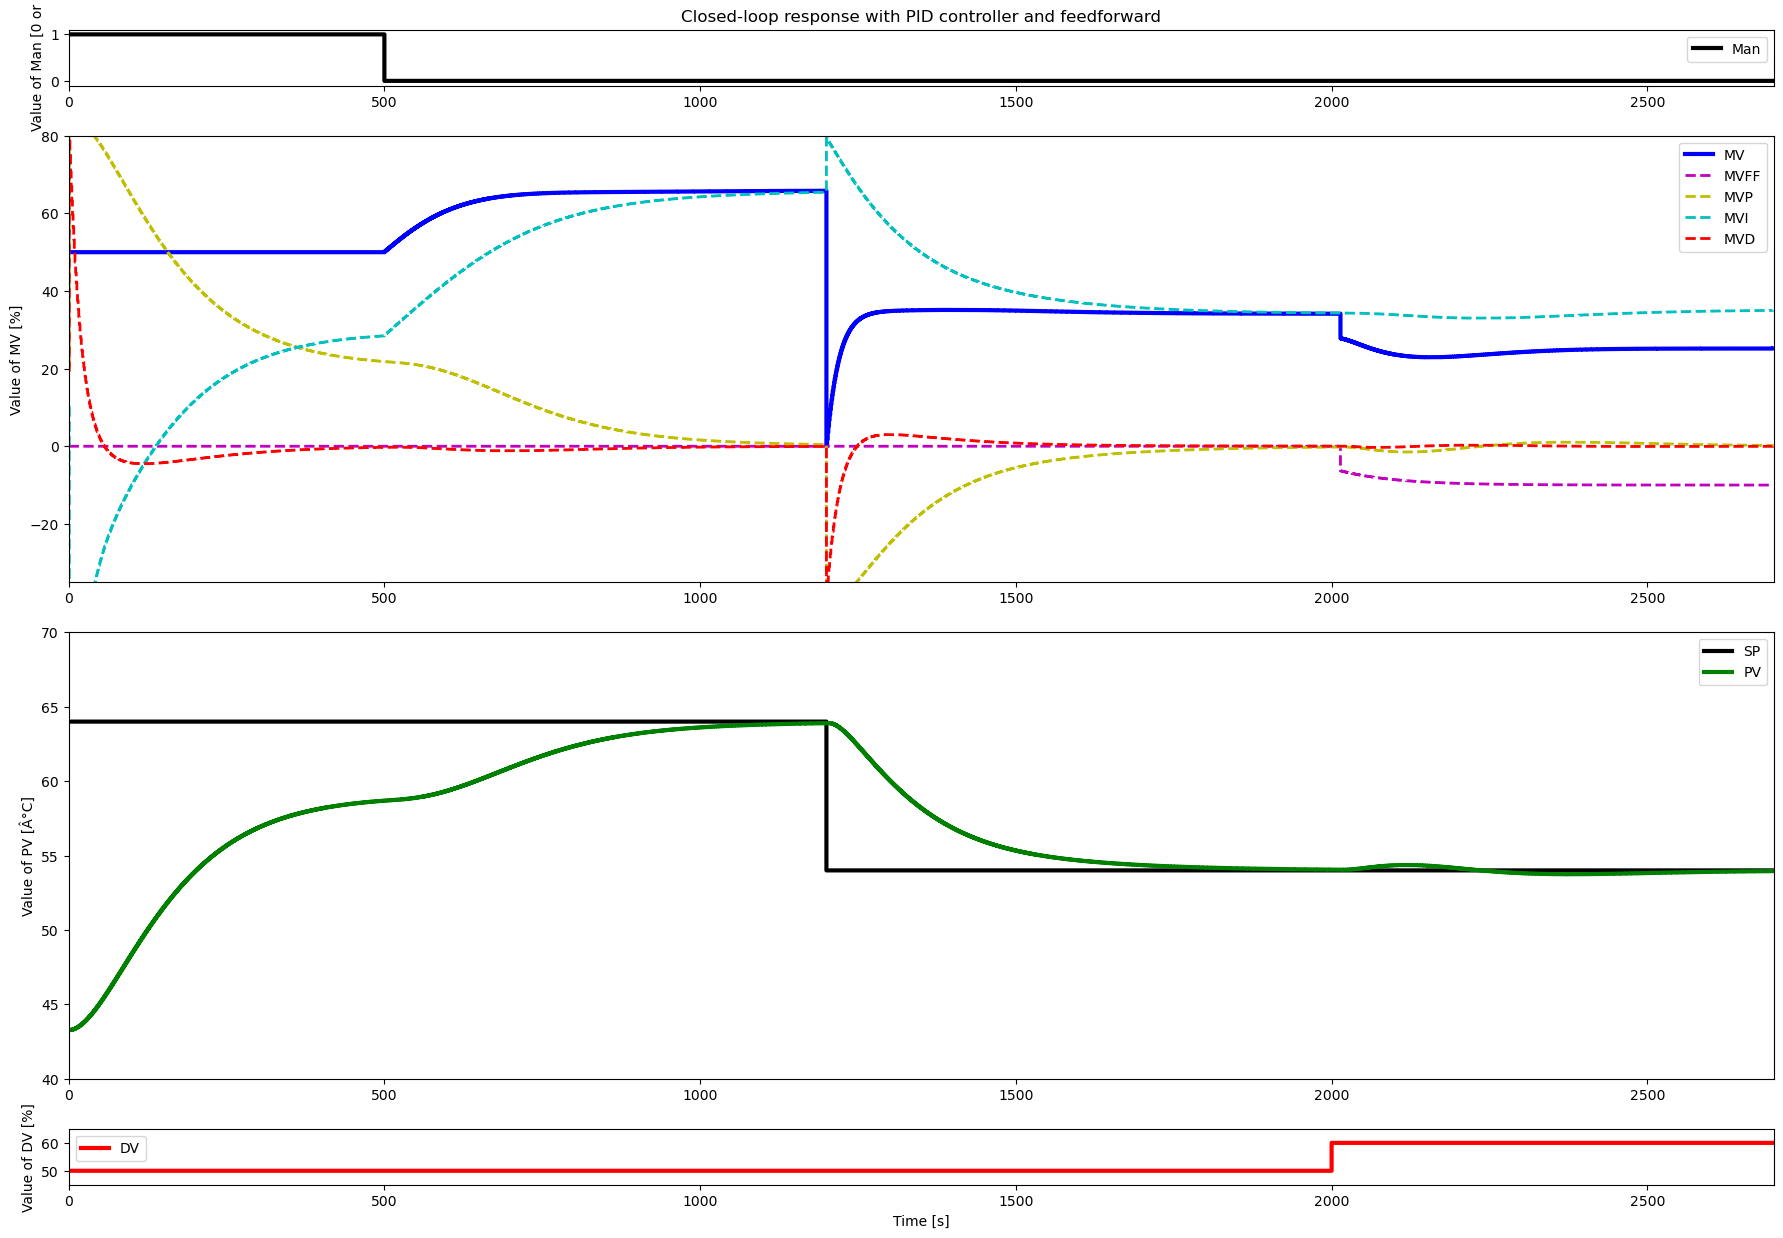

In [100]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, gridspec_kw={'height_ratios':[1, 8, 8, 1]})
fig.set_figheight(15)
fig.set_figwidth(22)

l1, = ax1.step([0,t[-1]],[0,100],'k-',linewidth=3,label="Man",where='post')
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title('Closed-loop response with PID controller and feedforward')
ax1.legend(loc='best')

l2, = ax2.step([0,t[-1]],[0,100],'b-',linewidth=3,label="MV",where='post')
l24, = ax2.step([0,t[-1]],[0,100],'--m',linewidth=2,label="MVFF",where='post')
l21, = ax2.step([0,t[-1]],[0,100],'--y',linewidth=2,label="MVP",where='post')
l22, = ax2.step([0,t[-1]],[0,100],'--c',linewidth=2,label="MVI",where='post')
l23, = ax2.step([0,t[-1]],[0,100],'--r',linewidth=2,label="MVD",where='post')
ax2.set_ylabel("Value of MV [%]")
ax2.legend(loc='best')

l3, = ax3.step([0,t[-1]],[0,100],'k-',linewidth=3,label="SP",where='post')
l4, = ax3.step([0,t[-1]],[0,100],'g-',linewidth=3,label="PV",where='post')
ax3.set_ylabel("Value of PV [Â°C]")
ax3.legend(loc='best')

l5, = ax4.step([0,t[-1]],[0,100],'r-',linewidth=3,label="DV",where='post')
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Value of DV [%]")
ax4.legend(loc='best')

ManInt = [int(x) for x in Man]

l1.set_data(t,ManInt)
l2.set_data(t,MV)
l21.set_data(t,MVP)
l22.set_data(t,MVI)
l23.set_data(t,MVD)
l24.set_data(t,MVff)
l3.set_data(t,SP)
l4.set_data(t,PV)
l5.set_data(t,DV)

ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)
ax3.set_xlim(0, t[-1]+1)
ax4.set_xlim(0, t[-1]+1)

MVMinscope = myRound(np.min([np.min(MV),np.min(MVP),np.min(MVI),np.min(MVD),np.min(MVff)]),5)-5
MVMaxscope = myRound(np.max([np.max(MV),np.max(MVP),np.max(MVI),np.max(MVD),np.max(MVff)]),5)+5

ax1.set_ylim(-0.1,1.1)
ax2.set_ylim(np.max([MVMinscope,-35]), np.min([MVMaxscope,80]))
ax3.set_ylim(np.max([myRound(np.min((np.min(PV),np.min(SP))),5)-5,40]), myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)

nameFile = 'Plots/Simulation_' 

if not os.path.exists('Plots'):
    os.makedirs('Plots')
    
#plt.savefig(nameFile + '.png',transparent=True)
#plt.savefig(nameFile + '.pdf',transparent=True)